### Library

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from surprise import Dataset, Reader, KNNBasic, accuracy
from surprise.model_selection import train_test_split
import numpy as np
import scipy.sparse as sp
import pickle
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from recmetrics import intra_list_similarity

#### muat dataset

In [2]:
df_anime = pd.read_csv('../dataset/df_anime.csv')
df_ratings = pd.read_csv('../dataset/df_ratings.csv')

### Content-based Filtering

In [3]:
df_anime.head(3)

,anime_id,name,english_name,genres,studios,image_url,content,content_prep
0,1,Cowboy Bebop,Cowboy Bebop,"Action, Award Winning, Sci-Fi",Sunrise,https://cdn.myanimelist.net/images/anime/4/196...,"Cowboy Bebop Sunrise Action, Award Winning, Sc...","['cowboy', 'bebop', 'sunris', 'action', 'award..."
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,"Action, Sci-Fi",Bones,https://cdn.myanimelist.net/images/anime/1439/...,"Cowboy Bebop: Tengoku no Tobira Bones Action, ...","['cowboy', 'bebop', 'tengoku', 'tobira', 'bone..."
2,6,Trigun,Trigun,"Action, Adventure, Sci-Fi",Madhouse,https://cdn.myanimelist.net/images/anime/7/203...,"Trigun Madhouse Action, Adventure, Sci-Fi","['trigun', 'madhous', 'action', 'adventur', 's..."


In [4]:
#menghitung nilai tf-idf dan cosine similarity antar iten
preprocessed_text_list = df_anime['content_prep'].tolist()
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(preprocessed_text_list)
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [5]:
# mendapatan term
terms = tfidf.get_feature_names_out()


top_terms = []

for i in range(min(10, tfidf_matrix.shape[0])):  # Ensure we don't go out of bounds if there are fewer than 10 rows
    row = tfidf_matrix.getrow(i).toarray().flatten()
    top_indices = row.argsort()[-10:][::-1]
    for idx in top_indices:
        top_terms.append({
            'anime_id': df_anime['anime_id'].iloc[i],
            'term': terms[idx],
            'tfidf': row[idx]
        })

# Clist dictionaries kedataframe
terms_df = pd.DataFrame(top_terms)

# menampilkan list term
terms_df.head(15)

,anime_id,term,tfidf
0,1,cowboy,0.571409
1,1,bebop,0.571409
2,1,award,0.338391
3,1,win,0.337261
4,1,sunris,0.266919
5,1,sci,0.168666
6,1,action,0.137971
7,1,hotarubi,0.000000
8,1,hottan,0.000000
9,1,hotori,0.000000


In [6]:
cosine_sim

array([[1.        , 0.57597773, 0.06693569, ..., 0.        , 0.01636619,
        0.01484155],
       [0.57597773, 1.        , 0.05503703, ..., 0.        , 0.0134569 ,
        0.01220328],
       [0.06693569, 0.05503703, 1.        , ..., 0.        , 0.02307039,
        0.0209212 ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.02289022,
        0.        ],
       [0.01636619, 0.0134569 , 0.02307039, ..., 0.02289022, 1.        ,
        0.02815389],
       [0.01484155, 0.01220328, 0.0209212 , ..., 0.        , 0.02815389,
        1.        ]])

In [7]:
def get_cbf_recommendations(anime_name, cosine_sim, topN=5):
    anime_name_lower = anime_name.lower()
    idx = df_anime.index[(df_anime['name'].str.lower() == anime_name_lower) | 
                         (df_anime['english_name'].str.lower() == anime_name_lower)].tolist()
    
    if not idx:
        return pd.DataFrame()
    
    idx = idx[0]  # Ambil indeks pertama, seharusnya hanya satu hasil yang cocok
    
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:topN+1]
    anime_indices = [i[0] for i in sim_scores]
    
    recommendations = pd.DataFrame({
        'anime_id': df_anime['anime_id'].iloc[anime_indices],
        'name': df_anime['name'].iloc[anime_indices],
        'model': ['Content Based Filtering' for _ in range(len(anime_indices))],
        'cosine_sim': [i[1] for i in sim_scores]
    })
    
    return recommendations.head()

In [8]:
anime_name_to_search = 'naruto'
recommendations_cbf = get_cbf_recommendations(anime_name_to_search, cosine_sim, topN=5)

# Display the recommendations DataFrame (if anime was found)
if recommendations_cbf is not None:
  print("Recommendations for", anime_name_to_search)

recommendations_cbf.head()

Recommendations for naruto


,anime_id,name,model,cosine_sim
4004,10075,Naruto x UT,Content Based Filtering,0.965021
4864,16870,The Last: Naruto the Movie,Content Based Filtering,0.888431
10558,53236,Road of Naruto,Content Based Filtering,0.766079
1312,1735,Naruto: Shippuuden,Content Based Filtering,0.757786
1822,2472,Naruto: Shippuuden Movie 1,Content Based Filtering,0.725384


### Collaborative Filtering

In [9]:
# Load and prepare the dataset for Surprise
reader = Reader(rating_scale=(1, 10))
rating_df = Dataset.load_from_df(df_ratings[['user_id', 'anime_id', 'rating']], reader)
trainset, testset = train_test_split(rating_df, test_size=0.2, random_state=42)

# Define and train the CF model
similarity = {"name": "cosine", "user_based": False}
algo_knn = KNNBasic(k=100, sim_options=similarity)
algo_knn.fit(trainset)
predictions = algo_knn.test(testset)

# Menghitung MAE untuk model CF
mae_cf = accuracy.mae(predictions)
print("MAE for CF Model:", mae_cf)

Computing the cosine similarity matrix...
Done computing similarity matrix.
MAE:  1.1167
MAE for CF Model: 1.1166823533499453


In [ ]:
k_values = [20, 40, 60, 80, 100]
results = []

for k in k_values:
    algo_knn = KNNBasic(k=k, sim_options=similarity)
    algo_knn.fit(trainset)
    predictions = algo_knn.test(testset)
    cf_mae = accuracy.mae(predictions, verbose=False)
    
    results.append({'K': k, 'mae': cf_mae})

# konversi hasil menjadi df
results_df = pd.DataFrame(results)
results_df.head(6)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


,K,mae
0,20,1.167538
1,40,1.133682
2,60,1.122592
3,80,1.117928
4,100,1.116682


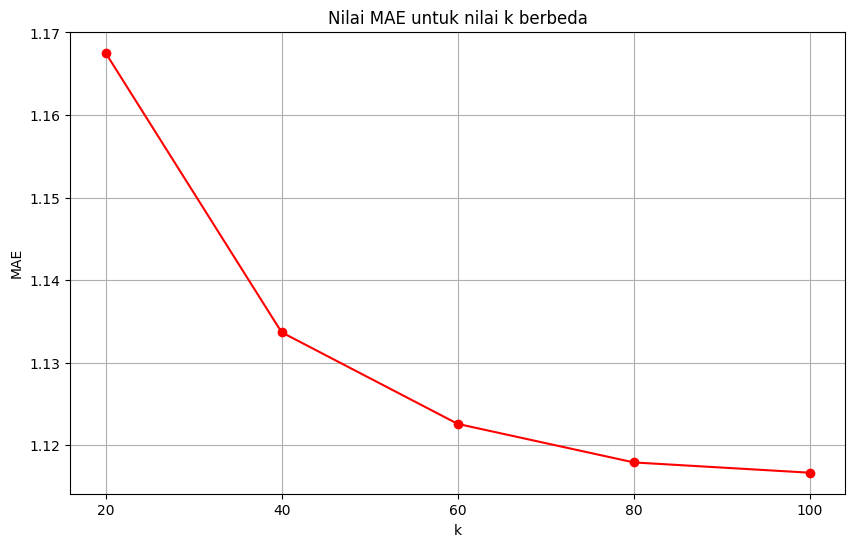

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(results_df['K'], results_df['mae'], marker='o', linestyle='-', color='r')
plt.title('Nilai MAE untuk nilai k berbeda')
plt.xlabel('k')
plt.ylabel('MAE')
plt.grid(True)
plt.xticks(k_values)
plt.savefig('mae_plot.png')

In [10]:
def get_cf_recommendations(user_id, topN=5):
    user_predictions = [pred for pred in predictions if pred.uid == user_id]
    if not user_predictions:
        return pd.DataFrame()
    user_predictions = sorted(user_predictions, key=lambda x: x.est, reverse=True)[:topN]
    result_data = []
    for pred in user_predictions:
        anime_id = pred.iid
        if anime_id not in df_anime['anime_id'].values:
            continue
        anime_title = df_anime.loc[df_anime['anime_id'] == anime_id, 'name'].iloc[0]
        model = 'Collaborative Filtering'
        est = pred.est
        result_data.append({'anime_id': anime_id, 'name': anime_title, 'model': model, 'est': est})
    return pd.DataFrame(result_data)


In [11]:
user_id = 1
recommendations_cf = get_cf_recommendations(user_id, topN=5)
print("Recommendations for user", user_id)
recommendations_cf.head()

Recommendations for user 1


,anime_id,name,model,est
0,72,Full Metal Panic? Fumoffu,Collaborative Filtering,7.960418
1,44,Rurouni Kenshin: Meiji Kenkaku Romantan - Tsui...,Collaborative Filtering,7.918655
2,153,Juuni Kokuki,Collaborative Filtering,7.917724
3,263,Hajime no Ippo,Collaborative Filtering,7.878930
4,256,Hoshi no Koe,Collaborative Filtering,7.858399


### Hybrid

In [12]:
def get_hybrid_recommendations(user_id, df_ratings, df_anime, cosine_sim, predictions, topN=10):
    user_rated_anime_ids = df_ratings[df_ratings['user_id'] == user_id]['anime_id'].unique()
    if len(user_rated_anime_ids) == 0:
        return pd.DataFrame()

    cbf_result = pd.DataFrame()
    for anime_id in user_rated_anime_ids:
        if anime_id not in df_anime['anime_id'].values:
            continue
        anime_name = df_anime.loc[df_anime['anime_id'] == anime_id, 'name'].values[0]
        cbf_recommendations = get_cbf_recommendations(anime_name, cosine_sim, topN)
        if cbf_recommendations is not None and not cbf_recommendations.empty:
            cbf_recommendations['sim/est'] = cbf_recommendations['cosine_sim']
            cbf_recommendations = cbf_recommendations.drop(columns=['cosine_sim'])
            cbf_result = pd.concat([cbf_result, cbf_recommendations])

    if not cbf_result.empty:
        # Normalize CBF cosine similarity values to a scale of 1-10
        cbf_result['sim/est'] = (cbf_result['sim/est'] - cbf_result['sim/est'].min()) / (cbf_result['sim/est'].max() - cbf_result['sim/est'].min()) * 9 + 1
        cbf_result = cbf_result.drop_duplicates(subset='anime_id', keep='first').head(topN // 2)
    else:
        cbf_result = pd.DataFrame()

    cf_result = get_cf_recommendations(user_id, topN // 2)
    if not cf_result.empty:
        cf_result['sim/est'] = cf_result['est']
        cf_result = cf_result.drop(columns=['est'])
    else:
        cf_result = pd.DataFrame()

    # Combine CBF and CF results
    recommended = cbf_result.to_dict('records') + cf_result.to_dict('records')
    recommended_df = pd.DataFrame(recommended)

    if recommended_df.empty:
        return pd.DataFrame()

    return recommended_df


In [13]:
# Pemanggilan fungsi get_hybrid_recommendations
user_id = 1
hybrid_recs = get_hybrid_recommendations(user_id, df_ratings, df_anime, cosine_sim, predictions, topN=10)

# Menampilkan rekomendasi
hybrid_recs.head(10)

,anime_id,name,model,sim/est
0,459,One Piece Movie 01,Content Based Filtering,9.134930
1,12859,One Piece Film: Z,Content Based Filtering,8.824962
2,8171,One Piece Recap,Content Based Filtering,8.222956
3,31490,One Piece Film: Gold,Content Based Filtering,6.760709
4,32051,One Piece: Adventure of Nebulandia,Content Based Filtering,6.658681
5,72,Full Metal Panic? Fumoffu,Collaborative Filtering,7.960418
6,44,Rurouni Kenshin: Meiji Kenkaku Romantan - Tsui...,Collaborative Filtering,7.918655
7,153,Juuni Kokuki,Collaborative Filtering,7.917724
8,263,Hajime no Ippo,Collaborative Filtering,7.878930
9,256,Hoshi no Koe,Collaborative Filtering,7.858399


### Evaluasi

#### MAE

In [27]:
# Ambil 100 sampel dari test set untuk perhitungan MAE
sample_testset = testset[:10000]

# Inisialisasi variabel untuk menyimpan nilai asli dan prediksi
true_ratings = []
predicted_ratings = []

for uid, iid, true_r in sample_testset:  # Hanya tiga elemen
    # Cari nama anime berdasarkan anime_id (iid)
    if iid not in df_anime['anime_id'].values:
        continue
    anime_name = df_anime.loc[df_anime['anime_id'] == iid, 'name'].values[0]
    
    # Dapatkan rekomendasi CBF untuk anime ini
    recommendations_cbf = get_cbf_recommendations(anime_name, cosine_sim, topN=10)
    
    # Cek apakah item yang sedang diuji ada dalam rekomendasi CBF
    if iid in recommendations_cbf['anime_id'].values:
        # Ambil prediksi dari model CBF untuk item ini
        est_r = recommendations_cbf[recommendations_cbf['anime_id'] == iid]['cosine_sim'].values[0]
    else:
        # Jika item tidak ada dalam rekomendasi, gunakan nilai rata-rata global atau fallback lainnya
        est_r = df_ratings['rating'].mean()  # Menggunakan rata-rata rating global
        
    # Simpan nilai asli dan prediksi
    true_ratings.append(true_r)
    predicted_ratings.append(est_r)

# Hitung MAE
mae_cbf = mean_absolute_error(true_ratings, predicted_ratings)
print(f"MAE untuk Content-Based Filtering: {mae_cbf}")

MAE untuk Content-Based Filtering: 1.4812335085285446


In [28]:
for uid, iid, true_r in sample_testset:  # Hanya tiga elemen
    # Cari prediksi untuk user_id (uid) dan anime_id (iid) di testset
    # predictions adalah hasil dari algo_knn.test(testset)
    pred = next((p for p in predictions if p.uid == uid and p.iid == iid), None)
    
    if pred:
        # Simpan nilai prediksi dari CF model
        est_r = pred.est
    else:
        # Jika tidak ada prediksi, gunakan rata-rata global atau fallback lainnya
        est_r = df_ratings['rating'].mean()
        
    # Simpan nilai asli dan prediksi
    true_ratings.append(true_r)
    predicted_ratings.append(est_r)

# Hitung MAE
mae_cf = mean_absolute_error(true_ratings, predicted_ratings)
print(f"MAE untuk Collaborative Filtering: {mae_cf}")

MAE untuk Collaborative Filtering: 1.289312003121565


In [ ]:
# Ambil 10,000 sampel dari test set
sample_testset = testset[:10000]

# Fungsi untuk memprediksi rating dengan hybrid
def predict_hybrid_rating(user_id, anime_id, cosine_sim, df_anime, algo_knn, weight_cbf=0.7, weight_cf=0.3):
    cbf_rating = predict_cbf_rating(user_id, anime_id, cosine_sim, df_anime)
    cf_rating = algo_knn.predict(user_id, anime_id).est
    
    if np.isnan(cbf_rating):
        return cf_rating
    elif np.isnan(cf_rating):
        return cbf_rating
    else:
        return weight_cbf * cbf_rating + weight_cf * cf_rating

# Fungsi untuk menghitung MAE untuk hybrid model
def calculate_mae_hybrid(test_data, cosine_sim, df_anime, algo_knn, weight_cbf=0.7, weight_cf=0.3):
    test_data['predicted_hybrid'] = test_data.apply(lambda x: predict_hybrid_rating(x['user_id'], x['anime_id'], cosine_sim, df_anime, algo_knn, weight_cbf, weight_cf), axis=1)
    test_data_clean = test_data.dropna(subset=['predicted_hybrid'])
    mae_hybrid = mean_absolute_error(test_data_clean['rating'], test_data_clean['predicted_hybrid'])
    return mae_hybrid

# Contoh penggunaan
mae_hybrid = calculate_mae_hybrid(pd.DataFrame(sample_testset, columns=['user_id', 'anime_id', 'rating']), cosine_sim, df_anime, algo_knn)
print(f"Hybrid MAE: {mae_hybrid}")

In [ ]:
from sklearn.metrics import mean_absolute_error

# Ambil 10.000 sampel dari test set untuk perhitungan MAE
sample_testset = testset[:10000]

# Inisialisasi variabel untuk menyimpan nilai asli, prediksi, dan cache
true_ratings = []
predicted_ratings = []
user_cache = {}

for uid, iid, true_r in sample_testset:
    # Cek apakah user sudah ada dalam cache
    if uid not in user_cache:
        # Dapatkan rekomendasi hybrid untuk user dan simpan dalam cache
        recommendations_hybrid = get_hybrid_recommendations(uid, df_ratings, df_anime, cosine_sim, predictions, topN=10)
        user_cache[uid] = recommendations_hybrid
    else:
        recommendations_hybrid = user_cache[uid]
    
    # Debug: Periksa struktur recommendations_hybrid
    if recommendations_hybrid.empty or 'anime_id' not in recommendations_hybrid.columns:
        print(f"Warning: Kolom 'anime_id' tidak ditemukan untuk user_id {uid}. Skipping...")
        continue  # Skip to the next loop iteration
    
    # Cek apakah item yang sedang diuji ada dalam rekomendasi hybrid
    if iid in recommendations_hybrid['anime_id'].values:
        # Ambil prediksi dari model hybrid untuk item ini
        est_r = recommendations_hybrid[recommendations_hybrid['anime_id'] == iid]['sim/est'].values[0]
    else:
        # Jika item tidak ada dalam rekomendasi, gunakan nilai rata-rata global atau fallback lainnya
        est_r = df_ratings['rating'].mean()  # Menggunakan rata-rata rating global
        
    # Simpan nilai asli dan prediksi
    true_ratings.append(true_r)
    predicted_ratings.append(est_r)

# Hitung MAE
mae_hybrid = mean_absolute_error(true_ratings, predicted_ratings)
print(f"MAE untuk Hybrid Model: {mae_hybrid}")


In [ ]:
def predict_cbf_rating(user_id, anime_id, cosine_sim, df_anime, train_data):
    user_anime_ratings = train_data[train_data['user_id'] == u   ser_id]
    
    if user_anime_ratings.empty:
        return np.nan  # Jika user tidak punya rating di training set
    
    similarities = []
    for _, row in user_anime_ratings.iterrows():
        watched_anime_id = row['anime_id']
        watched_rating = row['rating']
        
        idx_watched = df_anime.index[df_anime['anime_id'] == watched_anime_id].tolist()
        idx_unwatched = df_anime.index[df_anime['anime_id'] == anime_id].tolist()
        
        if not idx_watched or not idx_unwatched:
            continue
        
        idx_watched = idx_watched[0]
        idx_unwatched = idx_unwatched[0]
        
        similarity = cosine_sim[idx_watched, idx_unwatched]
        similarities.append((similarity, watched_rating))
    
    if len(similarities) == 0:
        return np.nan  # Jika tidak ada similarity yang dapat dihitung
    
    total_similarity = sum([sim for sim, rating in similarities])
    if total_similarity == 0:
        return np.nan  # Jika total similarity nol, tidak bisa memberikan prediksi
    
    weighted_ratings = sum([sim * rating for sim, rating in similarities])
    predicted_rating = weighted_ratings / total_similarity
    
    return predicted_rating

def calculate_mae_cbf(test_data, cosine_sim, df_anime, train_data):
    test_data['predicted_cbf'] = test_data.apply(lambda x: predict_cbf_rating(x['user_id'], x['anime_id'], cosine_sim, df_anime, train_data), axis=1)
    test_data_clean = test_data.dropna(subset=['predicted_cbf'])
    mae_cbf = mean_absolute_error(test_data_clean['rating'], test_data_clean['predicted_cbf'])
    return mae_cbf

# Contoh penggunaan
mae_cbf = calculate_mae_cbf(test_data, cosine_sim, df_anime, train_data)
print(f"CBF MAE: {mae_cbf}")


CBF MAE: 1.4960776494384807


In [ ]:
def predict_hybrid_rating(user_id, anime_id, cosine_sim, df_anime, train_data, algo_knn, weight_cbf=0.7, weight_cf=0.3):
    cbf_rating = predict_cbf_rating(user_id, anime_id, cosine_sim, df_anime, train_data)
    cf_rating = algo_knn.predict(user_id, anime_id).est
    
    if np.isnan(cbf_rating):
        return cf_rating
    elif np.isnan(cf_rating):
        return cbf_rating
    else:
        return weight_cbf * cbf_rating + weight_cf * cf_rating

def calculate_mae_hybrid(test_data, cosine_sim, df_anime, train_data, algo_knn, weight_cbf=0.7, weight_cf=0.3):
    test_data['predicted_hybrid'] = test_data.apply(lambda x: predict_hybrid_rating(x['user_id'], x['anime_id'], cosine_sim, df_anime, train_data, algo_knn, weight_cbf, weight_cf), axis=1)
    test_data_clean = test_data.dropna(subset=['predicted_hybrid'])
    mae_hybrid = mean_absolute_error(test_data_clean['rating'], test_data_clean['predicted_hybrid'])
    return mae_hybrid

# Contoh penggunaan
mae_hybrid = calculate_mae_hybrid(test_data, cosine_sim, df_anime, train_data, algo_knn)
print(f"Hybrid MAE: {mae_hybrid}")


Hybrid MAE: 1.1571845792018154


In [19]:
import numpy as np
import multiprocessing as mp

# Convert testset to DataFrame
test_data = pd.DataFrame(testset, columns=['user_id', 'anime_id', 'rating'])

# Cache hybrid recommendations
hybrid_cache = {}

def get_cached_hybrid_recommendations(user_id, df_ratings, df_anime, cosine_sim, predictions, hybrid_cache):
    if user_id not in hybrid_cache:
        hybrid_cache[user_id] = get_hybrid_recommendations(user_id, df_ratings, df_anime, cosine_sim, predictions)
    return hybrid_cache[user_id]

def process_user(user_id, test_data, hybrid_cache, df_ratings, df_anime, cosine_sim, predictions):
    hybrid_recommendations = get_cached_hybrid_recommendations(user_id, df_ratings, df_anime, cosine_sim, predictions, hybrid_cache)
    if hybrid_recommendations.empty:
        return 0, 0
    
    user_ratings = test_data[test_data['user_id'] == user_id]
    
    # Merge hybrid recommendations with user ratings
    merged_df = hybrid_recommendations.merge(user_ratings, on='anime_id', how='inner')
    
    if merged_df.empty:
        return 0, 0

    # Calculate weighted MAE
    merged_df['weight'] = np.where(merged_df['model'] == 'Content Based Filtering', 0.7, 0.3)
    merged_df['error'] = merged_df['weight'] * abs(merged_df['sim/est'] - merged_df['rating'])
    
    total_error = merged_df['error'].sum()
    total_count = len(merged_df)
    
    return total_error, total_count

def calculate_hybrid_mae(test_data, df_ratings, df_anime, cosine_sim, predictions):
    user_ids = test_data['user_id'].unique()
    hybrid_cache = {}

    # Use multiprocessing to speed up processing
    pool_args = [(user_id, test_data, hybrid_cache, df_ratings, df_anime, cosine_sim, predictions) for user_id in user_ids]
    with mp.Pool(mp.cpu_count()) as pool:
        results = pool.starmap(process_user, pool_args)
    
    total_error = sum([result[0] for result in results])
    total_count = sum([result[1] for result in results])
    
    mae_hybrid = total_error / total_count if total_count > 0 else None
    return mae_hybrid

# Usage example
mae_hybrid = calculate_hybrid_mae(test_data, df_ratings, df_anime, cosine_sim, predictions)
print("MAE for Hybrid Model:", mae_hybrid)


#### ILS

### Simpan Model

In [ ]:

# Simpan model CF, cosine similarity matrix, DataFrame, dan prediksi ke dalam file pickle
with open('cf_model.pkl', 'wb') as f:
    pickle.dump(algo_knn, f)
with open('cbf_cosine_sim.pkl', 'wb') as f:
    pickle.dump(cosine_sim, f)
with open('df_anime.pkl', 'wb') as f:
    pickle.dump(df_anime, f)
with open('predictions.pkl', 'wb') as f:
    pickle.dump(predictions, f)